## Libraries

In [1]:
# Common:
import struct
import numpy as np
import scipy.io.wavfile as wav
import resampy

# Features engineering:
from python_speech_features import mfcc, delta

# Sklearn tools:
from sklearn import model_selection, pipeline, preprocessing, svm, metrics

# Graphics:
import matplotlib.pyplot as plt

## Common params and settings

In [2]:
# Paths:

# Features:
SAMPLE_RATE = 16000
PREEMPHASIS_COEF = 0.95  # Coefficient for pre-processing filter
FRAME_LENGTH = 0.032  # Window length in sec
FRAME_STEP = 0.01  # Length of step in sec
WINDOW_FUNCTION = np.hamming  # Type of window function
NFFT = 512  # Points of FFT
NFILTERS = 26
CEPLIFTER = 22
APPEND_ENERGY = True
NFEATURES = 13  # Number of Mel filters

In [3]:
# Load data set for training:
mfcc_features = np.loadtxt('C:/Users/Alex/Desktop/My dreams/vad/mfcc_features_3.txt')


labels = np.zeros((mfcc_features.shape[0]))
data_feat = np.zeros((mfcc_features.shape[0], mfcc_features.shape[1] - 1))
for i in range(mfcc_features.shape[0]):
    labels[i] = mfcc_features[i][0]
    data_feat[i][:] = mfcc_features[i][1:]# + np.random.normal(0, 5, mfcc_features.shape[1] - 1)
    
X_train, X_test, y_train, y_test = train_test_split(data_feat, labels, train_size=0.95, random_state=40)

NameError: name 'train_test_split' is not defined

In [ ]:
# Calc MFCC:
path = 'C:/Users/Alex/Desktop/VAD/'
filename = 'Voice_002.wav'
#path = 'D:/Program/PyCharm Community Edition 2020.3.1/Projects/Voice/wav/'
#filename = 'Voice_Viktor Pchelkin_2648.wav'
wav = wavio.read(path + filename)
sound = wav.data
sample_rate = wav.rate

num_ceps = 13
features = np.zeros((1, 3 * num_ceps))
#features = np.zeros((1, num_ceps))

mfcc_feats = mfcc(sound, sample_rate, winlen=0.032, nfft=512, appendEnergy=True, winfunc=np.hamming)
d_mfcc = delta(mfcc_feats, 2)
d2_mfcc = delta(d_mfcc, 2)
dataset_on_sample = np.zeros((mfcc_feats.shape[0], 3 * num_ceps))
#dataset_on_sample = np.zeros((mfcc_feats.shape[0], num_ceps))
for j in range(mfcc_feats.shape[0]):
    dataset_on_sample[j][:num_ceps] = mfcc_feats[j][:]
    dataset_on_sample[j][num_ceps:2 * num_ceps] = d_mfcc[j][:]
    dataset_on_sample[j][2 * num_ceps:3 * num_ceps] = d2_mfcc[j][:]

mfcc_feat = np.concatenate((features, dataset_on_sample), axis=0)
mfcc_feat = np.delete(mfcc_feat, 0, axis=0)

#mfcc_feat -= (np.mean(mfcc_feat, axis=0) + 1e-8)
#mfcc_feat = normalize(mfcc_feat, norm='max')

In [ ]:
# Get vector combined labels:
def combine_labels(mfcc_feat, labels, sample_rate):
    start_frame = 0
    end_frame = int(sample_rate * 0.032)
    step_frame = int(sample_rate * 0.01)
    num_frames = mfcc_feat.shape[0]

    X_coor = np.zeros(num_frames)
    Y_coor = np.zeros(num_frames)
    Marker = np.zeros(num_frames)
    X_coor[0] = start_frame
    Y_coor[0] = end_frame

    for i in range(1, num_frames):
        start_frame += step_frame
        end_frame += step_frame
        X_coor[i] = start_frame
        Y_coor[i] = end_frame
        Marker[i] = labels[i]
        
    return X_coor, Y_coor, Marker, num_frames

In [ ]:
# Get plot:
def plot_result_VAD(sound, labels, X_coor, Y_coor, num_frames):
    plt.figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')
    for i in range(num_frames):
        if labels[i] == 1:
            color_bar = 'red'
        else:
            color_bar = 'white'
        plt.plot([X_coor[i], X_coor[i]], [-1, 1], color=color_bar)
        plt.plot([X_coor[i], Y_coor[i]], [1, 1], color=color_bar)
        plt.plot([Y_coor[i], Y_coor[i]], [-1, 1], color=color_bar)
    
    plt.plot(sound / max(abs(sound)), color='blue')

# Linear SVM

In [ ]:
clf_LSVC = make_pipeline(StandardScaler(), LinearSVC(random_state=0, max_iter=50000, tol=1e-5)).fit(X_train, y_train)

In [ ]:
labels_LSVC = clf_LSVC.predict(mfcc_feat)

In [ ]:
plot_roc_curve(clf_LSVC, X_test, y_test)

In [ ]:
op_LSVC = combine_labels(mfcc_feat, labels_LSVC, sample_rate)
plot_result_VAD(sound, op_LSVC[2], op_LSVC[0], op_LSVC[1], op_LSVC[3])

In [ ]:
labels_LSVC_new = medfilt(labels_LSVC, 51)
op_LSVC_new = combine_labels(mfcc_feat, labels_LSVC_new, sample_rate)
plot_result_VAD(sound, op_LSVC_new[2], op_LSVC_new[0], op_LSVC_new[1], op_LSVC_new[3])

In [11]:
clf_LSVC[1].coef_

array([[ 0.42312113,  0.55581767,  0.15499356,  0.32318509, -0.28367759,
        -0.12808963,  0.00715227,  0.02969692, -0.07958695, -0.02682161,
        -0.23189075, -0.19653115, -0.09467366, -0.0427234 , -0.0017646 ,
        -0.01982936, -0.00530833, -0.01035294,  0.00941022, -0.028494  ,
         0.00276689,  0.00891517,  0.01957693, -0.01280737,  0.02665126,
        -0.00388747,  0.10956189,  0.11640333,  0.04731162,  0.11674034,
        -0.11838895, -0.06489317,  0.01071915,  0.01949375, -0.04095057,
        -0.00704833, -0.11448222, -0.10295135, -0.05208734]])

In [12]:
clf_LSVC[1].intercept_

array([-1.67498369])

In [14]:
clf_LSVC.predict(mfcc_feat[700].reshape(1, -1))

array([1.])

In [84]:
#test_input = np.linspace(39, 77, 39)
#test_input = np.linspace(0, 38, 39)
test_input = np.linspace(78, 116, 39)
#(test_input - u) / s
scaled_test_input = clf_LSVC[0].transform(test_input.reshape(1, -1))
scaled_test_input

array([[ 19.74972839,   5.92876154,   7.08991808,   6.08284463,
          4.60931   ,   5.27525969,   5.27824685,   5.88213696,
          6.53521535,   6.69079198,   7.48089929,   7.7197619 ,
          8.10136641, 244.67947656,  44.94509246,  42.53553536,
         42.0648654 ,  35.84037605,  33.1262905 ,  32.99054972,
         33.84744274,  33.23803803,  34.06760818,  35.6060083 ,
         36.68569345,  38.85797873, 695.20042019, 130.4391887 ,
        117.3050336 , 116.12064383,  98.36434754,  89.233173  ,
         86.95303049,  88.20511567,  86.30797431,  87.79651725,
         91.55174248,  93.82600453,  99.1190978 ]])

In [85]:
test_input

array([ 78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116.])

In [86]:
clf_LSVC[1].coef_

array([[ 3.22767762e-01,  4.06085702e-01,  3.62539964e-01,
         2.13799276e-01, -3.95264931e-01, -2.92230974e-01,
        -3.51347670e-01, -1.09742292e-01, -4.07794836e-02,
         1.11297836e-01,  2.24575034e-02, -9.96415060e-03,
        -2.10568745e-01,  2.65349056e-03, -6.31265294e-03,
        -8.22606863e-03, -3.53202845e-03,  4.28434115e-03,
         4.12582744e-04,  3.36996175e-03,  1.84148614e-03,
        -6.00567607e-03, -1.18367130e-04,  6.13558070e-03,
        -5.57281203e-03,  4.04300012e-03,  1.06021551e-01,
         1.65016193e-01,  1.36318226e-01,  9.82143796e-02,
        -1.38099307e-01, -1.28877125e-01, -1.40444681e-01,
        -4.66569949e-02, -2.69032745e-02,  4.83070666e-02,
         6.39746827e-03, -3.65467595e-03, -1.10618137e-01]])

In [87]:
clf_LSVC.predict(scaled_test_input)

array([1.])

In [88]:
summ = 0
for i in range(len(scaled_test_input[0])):
    summ = summ + scaled_test_input[0][i] * clf_LSVC[1].coef_[0][i]
    print(summ)

6.374575630280597
8.78216092078479
11.352539565797748
12.653047341852835
10.831148745833705
9.289554465841958
7.435054736889684
6.789535544389963
6.523032837119927
7.267703503244188
7.435705824779508
7.358784954615152
5.652890398928283
6.3021450809368
6.018422310843037
5.6685220778063385
5.519947776292215
5.67350017440909
5.687167510234546
5.798344401055405
5.860673997725113
5.661057108222766
5.6570246232155785
5.875488160416924
5.671045686805524
5.828148499416175
79.53437544102628
101.05895379170917
117.04976783908351
128.45448482641055
114.87043659157455
103.37032177344909
91.15823114872012
87.04284551518127
84.7208783928217
88.9620705983248
89.54776996601828
89.20486632363539
78.24049638304771


In [89]:
u = clf_LSVC[0].mean_
s = clf_LSVC[0].scale_
new_mfcc_feat = (mfcc_feat[700] - u) / s

In [90]:
np.dot(clf_LSVC[1].coef_, scaled_test_input.T) + clf_LSVC[1].intercept_

array([[77.87291885]])

In [91]:
clf_LSVC[1].intercept_

array([-0.36757753])

In [92]:
np.dot(clf_LSVC[1].coef_, scaled_test_input.T)

array([[78.24049638]])

In [27]:
clf_LSVC[1].coef_[0]

array([ 3.22767762e-01,  4.06085702e-01,  3.62539964e-01,  2.13799276e-01,
       -3.95264931e-01, -2.92230974e-01, -3.51347670e-01, -1.09742292e-01,
       -4.07794836e-02,  1.11297836e-01,  2.24575034e-02, -9.96415060e-03,
       -2.10568745e-01,  2.65349056e-03, -6.31265294e-03, -8.22606863e-03,
       -3.53202845e-03,  4.28434115e-03,  4.12582744e-04,  3.36996175e-03,
        1.84148614e-03, -6.00567607e-03, -1.18367130e-04,  6.13558070e-03,
       -5.57281203e-03,  4.04300012e-03,  1.06021551e-01,  1.65016193e-01,
        1.36318226e-01,  9.82143796e-02, -1.38099307e-01, -1.28877125e-01,
       -1.40444681e-01, -4.66569949e-02, -2.69032745e-02,  4.83070666e-02,
        6.39746827e-03, -3.65467595e-03, -1.10618137e-01])

In [28]:
def float_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])

list_hex = []
for i in range(len(clf_LSVC[1].coef_[0])):
    list_hex.append(float_to_hex(clf_LSVC[1].coef_[0][i]))

In [29]:
list_strings = []
for i in range(39):
    list_strings.append("assign weights_SVM[" + str(i) + "] = 32'h" + str(list_hex[i][2:]) + ";")

In [30]:
list_strings

["assign weights_SVM[0] = 32'h3ea541d1;",
 "assign weights_SVM[1] = 32'h3ecfea77;",
 "assign weights_SVM[2] = 32'h3eb99ed7;",
 "assign weights_SVM[3] = 32'h3e5aee33;",
 "assign weights_SVM[4] = 32'hbeca602a;",
 "assign weights_SVM[5] = 32'hbe959f4c;",
 "assign weights_SVM[6] = 32'hbeb3e3d7;",
 "assign weights_SVM[7] = 32'hbde0c091;",
 "assign weights_SVM[8] = 32'hbd270863;",
 "assign weights_SVM[9] = 32'h3de3f01f;",
 "assign weights_SVM[10] = 32'h3cb7f8cc;",
 "assign weights_SVM[11] = 32'hbc2340ad;",
 "assign weights_SVM[12] = 32'hbe579f55;",
 "assign weights_SVM[13] = 32'h3b2de62f;",
 "assign weights_SVM[14] = 32'hbbceda5f;",
 "assign weights_SVM[15] = 32'hbc06c6a2;",
 "assign weights_SVM[16] = 32'hbb67799b;",
 "assign weights_SVM[17] = 32'h3b8c63a9;",
 "assign weights_SVM[18] = 32'h39d84feb;",
 "assign weights_SVM[19] = 32'h3b5cda94;",
 "assign weights_SVM[20] = 32'h3af15e05;",
 "assign weights_SVM[21] = 32'hbbc4cb43;",
 "assign weights_SVM[22] = 32'hb8f83bde;",
 "assign weights_SVM[

# labels

697758 341582


(array([0., 0., 0., ..., 0., 0., 0.]),
 array([697757.5       , 697757.50000293, 697757.50000586, ...,
        697758.49999414, 697758.49999707, 697758.5       ]),
 <a list of 341582 Patch objects>)

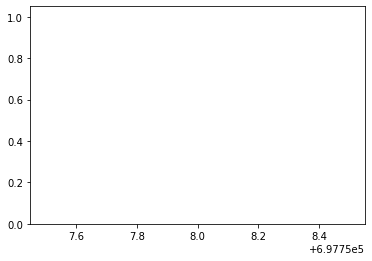

In [33]:
count_ones = 0
for i in range(len(labels)):
    if labels[i] == 1:
        count_ones = count_ones + 1
        
count_zeros = len(labels) - count_ones

print(count_zeros, count_ones)

In [39]:
# 1-d:
def write_1d(input_vec, filename):
    txt_list = []
    for i in range(len(input_vec)):
        if i == 0:
            txt_list.append('{ ')
        txt_list.append(str(input_vec[i]))
        if i == len(input_vec) - 1:
            txt_list.append(' },')
        else:
            txt_list.append(', ')
        
    f = open(filename, 'w')
    f.writelines(txt_list)
    f.close()

In [40]:
# 2-d:
def write_2d(input_vec, filename):
    txt_list = []
    for i in range(input_vec.shape[0]):
        for j in range(input_vec.shape[1]):
            if j == 0:
                txt_list.append('{ ')
            txt_list.append(str(input_vec[i][j]))
            if j == input_vec.shape[1] - 1:
                txt_list.append(' },')
            else:
                txt_list.append(', ')
                
    f = open(filename, 'w')
    f.writelines(txt_list)
    f.close()

In [41]:
write_1d(mfcc_feat[0], 'test_input.txt')
write_1d(np.linspace(0, 38, 39), 'test_input_counter.txt')
write_1d(clf_MLP.coefs_[1], 'coefs_second.txt')
write_1d(clf_MLP.intercepts_[0], 'intercepts_first.txt')

In [42]:
write_2d(clf_MLP.coefs_[0], 'coefs_first.txt')

In [43]:
clf_MLP.intercepts_[1]

array([-1.88764714])

In [44]:
a = np.array([10, 11, 12, 6, 3, 2, 6, 8, 1, 4, 6, 7, 8, 3, 1, 5, 78, 52, 5, 6, 7, 52])
b = medfilt(a, 3)

In [45]:
b

array([10., 11., 11.,  6.,  3.,  3.,  6.,  6.,  4.,  4.,  6.,  7.,  7.,
        3.,  3.,  5., 52., 52.,  6.,  6.,  7.,  7.])

In [2]:
kernel_size = 41
test = np.linspace(0, kernel_size - 1, kernel_size)

In [4]:
medfilt(test, kernel_size)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20.])